In [1]:
from anisotropy import run_SEPevent, select_sc_inst, print_available_channels

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.stattools import q_stat, acf

from itertools import product
import copy

SOLO_SECTORS = ["sun", "asun", "north", "south"]
WIND_SECTORS = [f"P{i}" for i in range(8)]

In [2]:
data_path = f"{os.getcwd()}{os.sep}data"

species = "e"
channels = [14,18]
averaging = "1min"

solo_start = pd.to_datetime('2023-10-30 00:00:00')
solo_end = pd.to_datetime('2023-11-01 00:00:00')
wind_start = pd.to_datetime('2021-10-28 00:00:00')
wind_end = pd.to_datetime('2021-10-30 00:00:00')

solo_event = run_SEPevent(data_path, "Solar Orbiter EPT", solo_start, solo_end, species, channels=channels, averaging=averaging)
wind_event = run_SEPevent(data_path, "Wind 3DP", wind_start, wind_end, species, channels=3, averaging=averaging)

Spacecraft: Solar Orbiter
Instrument: EPT. Species: e. Channels: [14, 18].
Cadence is 1.0 s.
Loading MAG...
Loading MAG...
RED = INWARD, negative polarity, [90, 270] degrees
BLUE = OUTWARD, positive polarity, [270, 360] and [0, 90] degrees
Calculating PA coverage for EPT...


  0%|          | 0/2880 [00:00<?, ?it/s]

Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.


02-Nov-25 18:30:14: File is current: c:\Users\osant\Desktop\Gradu\koodit\data\wind_masters/wi_h0_mfi_00000000_v01.cdf
02-Nov-25 18:30:14: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2021/
02-Nov-25 18:30:16: File is current: c:\Users\osant\Desktop\Gradu\koodit\data\mfi/mfi_h0/2021/wi_h0_mfi_20211028_v05.cdf
02-Nov-25 18:30:17: File is current: c:\Users\osant\Desktop\Gradu\koodit\data\mfi/mfi_h0/2021/wi_h0_mfi_20211029_v05.cdf


In [48]:
def get_sectors(sc):
    if sc.lower() == "solo":
        return SOLO_SECTORS

    elif sc.lower() == "wind":
        return WIND_SECTORS

def convert_to_bool_coverage(cov, sc, bin_width_deg=1):
    directions = get_sectors(sc)
    
    X, Y = np.meshgrid(cov.index.values, np.linspace(0, 180, int(180 / bin_width_deg)), indexing="ij")
    cov_arr = np.zeros_like(Y, dtype=np.bool_)

    for direction in directions:
        dataf = cov[direction].mask(cov[direction].isna(), -1)     # replace missing values with -1 to exclude from comparison in the loop
        for index, data in dataf.reset_index().iterrows():
            covered = np.ma.masked_inside(Y[index], data["min"], data["max"])
            cov_arr[index] = cov_arr[index] | covered.mask

    return X, Y, cov_arr

def coverage_overlap(cov1, cov2):
    return cov1 & cov2

def intensity_histogram(I_data, coverage):
    """
    Code partly adapted from SOLER anisotropy tools (maintained by Jan Gieseler) 
    https://github.com/soler-he/sep_tools/tree/main/anisotropy commit 7567a98f2179529a8e1ec5e00cba6993b58bf49e
    """ 
    intensity = copy.copy(I_data)
    sectors = get_sectors("Wind")

    X, Y = np.meshgrid(coverage.index.values, np.arange(180)+1)
    hist = np.zeros(np.shape(X))
    hist_counts = np.zeros(np.shape(X))

    for i, direction in enumerate(sectors):
        intensity_per_sector = intensity[:,i]
        cov_arr = coverage[direction].to_numpy()
        cov_finite = coverage[direction].notna().to_numpy()
        av_flux = np.where(cov_finite[:,1], intensity_per_sector, np.nan)   # Weird truth value behaviour. np.nan == True in the context of np.where, but in comparisons always false
        new_hist = np.where(((Y > cov_arr[:,0]) & (Y < cov_arr[:,2])), av_flux, 0)
        hist = hist + new_hist
        hist_counts = hist_counts + np.where(new_hist > 0, 1, 0)

    hist = hist / hist_counts
    hist = np.where(hist > 0, hist, np.nan)

    return hist

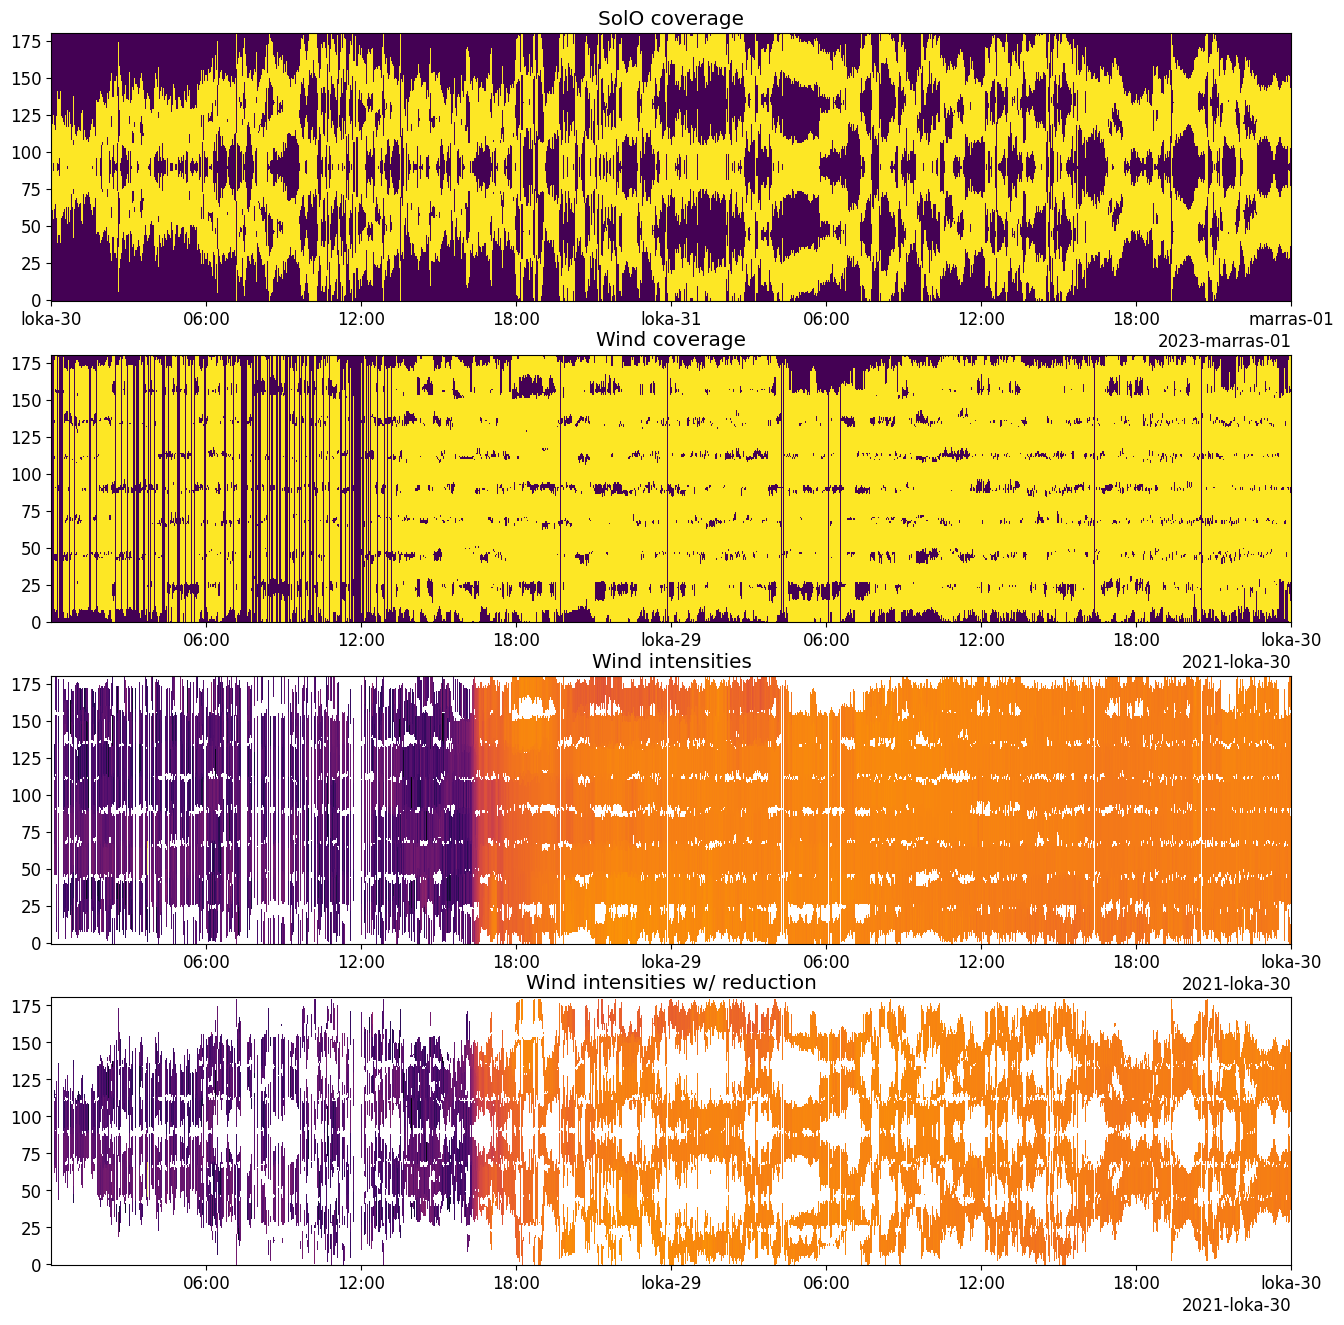

In [49]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=4, figsize=(16,16))
bin_width_deg = 1
solo_cov = solo_event.coverage
wind_cov = wind_event.coverage

X1, Y1, solo_cov_bool = convert_to_bool_coverage(solo_cov, "solo", bin_width_deg=bin_width_deg)
X2, Y2, wind_cov_bool = convert_to_bool_coverage(wind_cov, "wind", bin_width_deg=bin_width_deg)

cov_arr = coverage_overlap(solo_cov_bool, wind_cov_bool)

hist = intensity_histogram(wind_event.I_data, wind_cov)
hist_min = np.nanmin(hist)
hist_max = np.nanmax(hist)

axs[0].pcolormesh(X1, Y1, solo_cov_bool)
axs[0].set_title("SolO coverage")
axs[1].pcolormesh(X2, Y2, wind_cov_bool)
axs[1].set_title("Wind coverage")
axs[2].pcolormesh(X2, Y2, np.where(wind_cov_bool == True, hist.T, 0), norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[2].set_title("Wind intensities")
axs[3].pcolormesh(X2, Y2, np.where(cov_arr == True, hist.T, 0), norm=LogNorm(hist_min, hist_max), cmap="inferno")
axs[3].set_title("Wind intensities w/ reduction")
plt.show()

In [ ]:
def random_walk(data, mu=0, sigma=1):
    """Generate random coverage as Gaussian random walk.

    Args:
        start (datetime): start datetime (pd.Timestamp)
        end (datetime): end datetime (pd.Timestamp)
        n_channels (int): amount of channels
    """
    return np.cumsum(np.random.normal(mu, sigma, size=len(data)))

def coverage_overlap(cov1, cov2):
    """
    Determine coverage overlap of two pitch angle coverages.

    Args:
        cov1/cov2 (DataFrame): pitch angle coverage (min, center, max)
    
    Returns:
        cov_overlap (DataFrame): coverage where both overlap
    """
    cov_overlap = copy.copy(cov2)
    for index in range(len(cov2)):
        # If the minimum is larger than the other's maximum (or vice versa), coverages don't overlap -> set to NA
        if cov1.iloc[index, 0] > cov2.iloc[index, 2] or cov1.iloc[index, 2] < cov2.iloc[index, 0]:
            cov_overlap.iloc[index, :] = pd.NA

        # Else, if cov1's minimum is larger than cov2's minimum, set cov1 as minimum. The maximum has to be
        # the smallest of the two maximums
        elif cov1.iloc[index, 0] > cov2.iloc[index, 0]:
            cov_overlap.iloc[index, 0] = cov1.iloc[index, 0]
            cov_overlap.iloc[index, 2] = min(cov1.iloc[index, 2], cov2.iloc[index, 2])

        elif cov1.iloc[index, 0] < cov2.iloc[index, 0]:
            cov_overlap.iloc[index, 0] = cov2.iloc[index, 0]
            cov_overlap.iloc[index, 2] = min(cov1.iloc[index, 2], cov2.iloc[index, 2])

    # calculate new center as arithmetic mean
    cov_overlap.iloc[:, 1] = cov_overlap.iloc[:,[0, 2]].mean(axis=1)
    
    return cov_overlap

solo_dir = ["sun", "asun", "north", "south"]
wind_dir = [f"P{i}" for i in range(0, 8)]